In [1]:
from tomoSegmentPipeline.utils.common import read_array, write_array
from tomoSegmentPipeline.utils import setup

from mwReconstruction.dataloader import destripeDataSet

import numpy as np
import matplotlib.pyplot as plt
import random
import mrcfile
import pandas as pd
import torch
from torch.utils.data import Dataset
import os
from glob import glob
import scipy.io as io
# from skimage.metrics import structural_similarity as ssim
# from skimage.metrics import normalized_mutual_information as nmi
from scipy import ndimage
from joblib import Parallel, delayed

PARENT_PATH = setup.PARENT_PATH
ISONET_PATH = os.path.join(PARENT_PATH, 'data/isoNet/')

%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

In [4]:
cet_path = os.path.join(ISONET_PATH, 'RAW_dataset/RAW_allTomos_deconv/tomo10.mrc')    

my_dataset = destripeDataSet(path = cet_path, logTransform=False)
len(my_dataset)

# Understanding GCN

GCN is called as part of the main model:

```python
def forward(self, xc, weight_matrix, outlier_mask):
```
Okay, so first things first: 
- xc is the 2D image slice
- weight_matrix is the normalized log power matrix
- outlier_mask is the binary array with ones whenever the weight_matrix is below the 0.95 quantile

Now we breakdown the nasty inner code:

```python
        xcf = fft.fftshift(fft.fft2(xc))
        m, n = xcf.size()
        x0_neg = torch.masked_select(xcf, self.symmask == -1).unsqueeze(1)
        hier_mask = ((weight_matrix > 0.2) | (outlier_mask == 1)).float()
        hier_mask_neg = torch.masked_select(hier_mask, self.symmask == -1)
        weight_matrix_neg = torch.masked_select(weight_matrix, self.symmask == -1)
```

In [10]:
############# REFERENCE CODE ##########################
# xcf = fft.fftshift(fft.fft2(xc))
# m, n = xcf.size()

from mwReconstruction.model import *

input_2d_slice = my_dataset.x_data[len(my_dataset)//2][0].squeeze()
input_2d_slice.shape

fourier_2d_slice = fft.fftshift(fft.fft2(input_2d_slice))

m, n = fourier_2d_slice.size()

We need to define what symmask is, but this is outside the logic of the forward function

In [64]:
symmatrix = make_symmatrix(n, m)  # this is an np.array
symmask = torch.from_numpy(symmatrix).float()

symmask.shape, fourier_2d_slice.shape

(torch.Size([464, 928]), torch.Size([464, 928]))

(array([  2996.,  18962.,  92831., 132801.,  69284.,  39904.,  29644.,
         21592.,  15008.,   7570.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

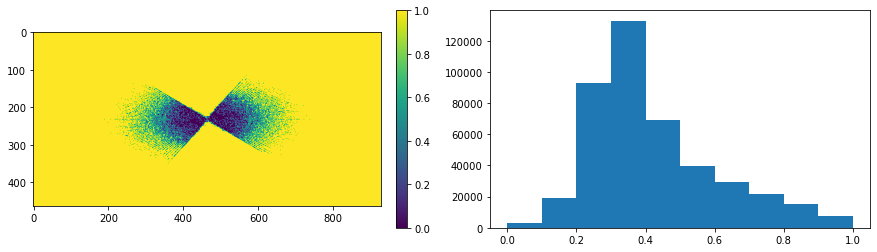

In [57]:
outlier_mask = my_dataset.x_data[len(my_dataset)//2][1].squeeze()
weight_matrix = my_dataset.x_data[len(my_dataset)//2][2].squeeze()
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 4))

plot0 = ax0.imshow(outlier_mask)
plt.colorbar(plot0, ax=ax0, fraction=0.046, pad=0.04)

ax1.hist(weight_matrix.flatten().numpy())

In [33]:
np.unique(symmask, return_counts=True)

(array([-1.,  0.,  1.], dtype=float32), array([215528,      1, 215063]))

In [ ]:
####################### REFERENCE #####################################
# x0_neg = torch.masked_select(xcf, self.symmask == -1).unsqueeze(1)

x0_neg = torch.masked_select(fourier_2d_slice, symmask == -1).unsqueeze(1) # shape: (N negative Fourier coefficients, 1)
x0_neg.shape

In [37]:
torch.quantile(weight_matrix, 0.95)

tensor(0.8059)

In [45]:
############################### REFERENCE ######################################
# hier_mask = ((weight_matrix > 0.2) | (outlier_mask == 1)).float() # not needed because quantile filtering includes > 0.2 OR case
# hier_mask_neg = torch.masked_select(hier_mask, self.symmask == -1)
# weight_matrix_neg = torch.masked_select(weight_matrix, self.symmask == -1)

outlier_mask_neg = torch.masked_select(outlier_mask, symmask == -1) # originally hier_mask_neg
weight_matrix_neg = torch.masked_select(weight_matrix, symmask == -1)
outlier_mask_neg.shape

torch.Size([215528])

So, up to this point what we have is the flattened negative fourier coefficients, and their corresponding weight and outlier masks.

Now this other part

```python
        _, mask_ind = torch.sort(
            torch.cat(
                [
                    torch.where(self.symmask.reshape(-1) == index)[0]
                    for index in [-1, 0, 1]
                ]
            )
        )
        _, mask_ind_neg = torch.sort(
            torch.cat(
                [
                    torch.where(hier_mask_neg.reshape(-1) == index)[0]
                    for index in range(2)
                ]
            )
        )
        N_neg = self.N_neg[:, hier_mask_neg == 0]
```

In [70]:
symmask_dummy = torch.tensor(make_symmatrix(4, 4))
symmask_dummy

tensor([[-1, -1, -1,  1],
        [-1, -1, -1,  1],
        [-1, -1,  0,  1],
        [-1, -1,  1,  1]])

In [71]:
_, mask_ind = torch.sort(
            torch.cat(
                [
                    torch.where(symmask_dummy.reshape(-1) == index)[0]
                    for index in [-1, 0, 1]
                ]
            )
        )

In [77]:
aux = torch.cat(
                [
                    torch.where(symmask_dummy.reshape(-1) == index)[0]
                    for index in [-1, 0, 1]
                ]
            )
torch.sort(aux)

torch.return_types.sort(
values=tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
indices=tensor([ 0,  1,  2, 11,  3,  4,  5, 12,  6,  7, 10, 13,  8,  9, 14, 15]))

In [99]:
torch.where(symmask_dummy.flatten() == -1)[0]

tensor([ 0,  1,  2,  4,  5,  6,  8,  9, 12, 13])

In [78]:
aux

tensor([ 0,  1,  2,  4,  5,  6,  8,  9, 12, 13, 10,  3,  7, 11, 14, 15])

In [86]:
aux_neg = make_N_neg_matrix(dr=3,
                            neg_mask=(symmatrix == -1).astype(int),
                            power_mask=outlier_mask.cpu().numpy(),
                        ).to_numpy()
N_neg = torch.from_numpy(aux_neg.transpose(1, 0)).long()
print(N_neg.shape)
# select only the indices that correspond to high power (non corrupted) coefficients
N_neg = N_neg[:, outlier_mask_neg == 0]
N_neg.shape

torch.Size([65, 215528])


torch.Size([65, 10765])

In [92]:
_, mask_ind_neg = torch.sort(
            torch.cat(
                [
                    torch.where(outlier_mask_neg.reshape(-1) == index)[0]
                    for index in range(2)
                ]
            )
        )
mask_ind_neg.shape

torch.Size([215528])

```python
self.MGNN1(
            x_neg=x0_neg, 
            hier_mask_neg=hier_mask_neg,
            N_neg=N_neg,
            mask_ind_neg=mask_ind_neg,
            weight_matrix_neg=weight_matrix_neg,
            mask_ind=mask_ind,
            m=m,
            n=n,
            aver=xc.sum().reshape(1, 1),
            k_neighbors=self.k_neighbors,
        )
```

In [ ]:
data = destripeDataSet(cet_path, l = l, logTransform=True)
# what happened to: data = tmp.x_data.squeeze().cuda()
train_loader = Data.DataLoader(dataset = data,
                               batch_size = 5,
                               shuffle = False
                               )
print('data loading finished')

In [ ]:

model = MGNNds(xc = _data[0, :, :], 
               weight_matrix = _data[2, :, :],
               outlier_mask = _data[1, :, :]).cuda()    
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
loss = Loss().cuda()
for epoch in range(500):
    model, _, recon, stripe = train(model, train_loader, optimizer, loss, epoch)

In [6]:
data = tmp.x_data.squeeze().cuda()
model = MGNNds(xc = data[0, :, :], 
               weight_matrix = data[2, :, :],
               outlier_mask = data[1, :, :]).cuda()    
output = model(xc = data[0, :, :], 
               weight_matrix = data[2, :, :],
               outlier_mask = data[1, :, :])    
print('parameters:', sum(param.numel() for param in model.parameters() if param.requires_grad))

parameters: 1250


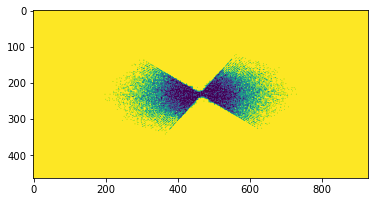

In [24]:
plt.imshow(data[1].cpu().numpy())

think how to deal with the case of no neighbors. Maybe drop them? **Upsample the existing neighbors**? Use less neighbors is not feasible for the task.

Maybe focus only on some smaller set of coefficients?

# Train model

In [191]:
import torch.utils.data
import argparse
import numpy as np
import torch
import random 
import torch.utils.data as Data
import scipy.io as io


l = [0, 1]

torch.backends.cudnn.enabled = True
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True 
setup_seed(2020)  



data loading finished


Train	 Epoch:   0 [     0/     1 (  0%)]	Loss: 230881525760.000000	TVLoss: 6813.812988	SIM: 0.661186
Train	 Epoch:   1 [     0/     1 (  0%)]	Loss: 215253975040.000000	TVLoss: 6958.290039	SIM: 0.662061
Train	 Epoch:   2 [     0/     1 (  0%)]	Loss: 200209743872.000000	TVLoss: 7115.434570	SIM: 0.662804
Train	 Epoch:   3 [     0/     1 (  0%)]	Loss: 185748586496.000000	TVLoss: 7279.597656	SIM: 0.663417
Train	 Epoch:   4 [     0/     1 (  0%)]	Loss: 171869241344.000000	TVLoss: 7448.484375	SIM: 0.663901
Train	 Epoch:   5 [     0/     1 (  0%)]	Loss: 158574379008.000000	TVLoss: 7621.009277	SIM: 0.664258
Train	 Epoch:   6 [     0/     1 (  0%)]	Loss: 145866358784.000000	TVLoss: 7796.492188	SIM: 0.664492
Train	 Epoch:   7 [     0/     1 (  0%)]	Loss: 133746966528.000000	TVLoss: 7974.628906	SIM: 0.664603
Train	 Epoch:   8 [     0/     1 (  0%)]	Loss: 122218176512.000000	TVLoss: 8155.264160	SIM: 0.664595
Train	 Epoch:   9 [     0/     1 (  0%)]	Loss: 111281315840.000000	TVLoss: 8338.324219	SIM:

(-0.5, 728.5, 728.5, -0.5)

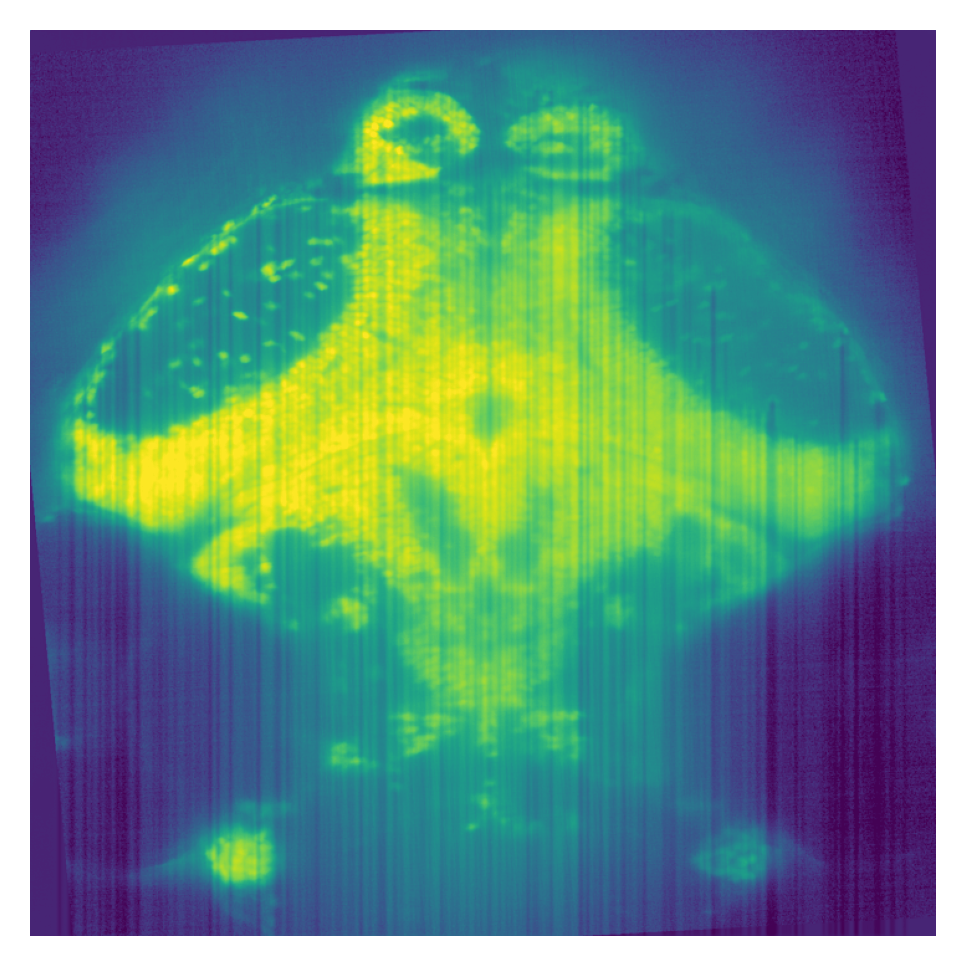

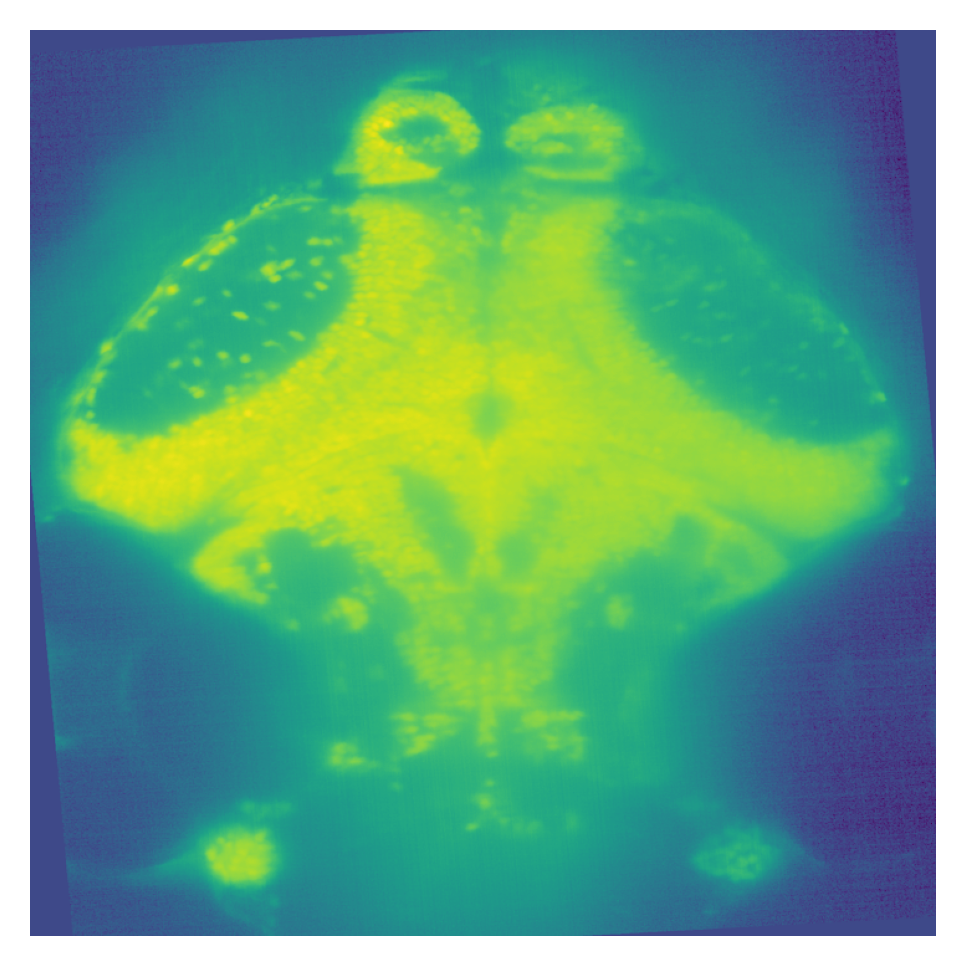

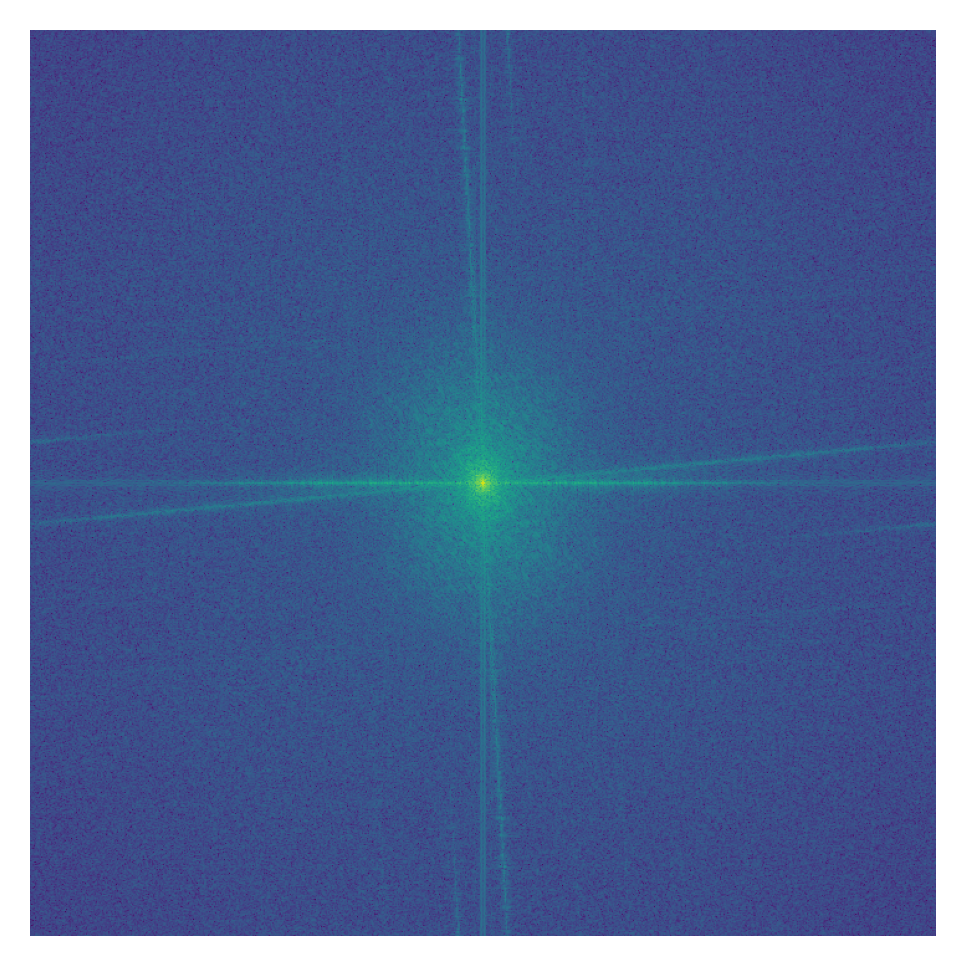

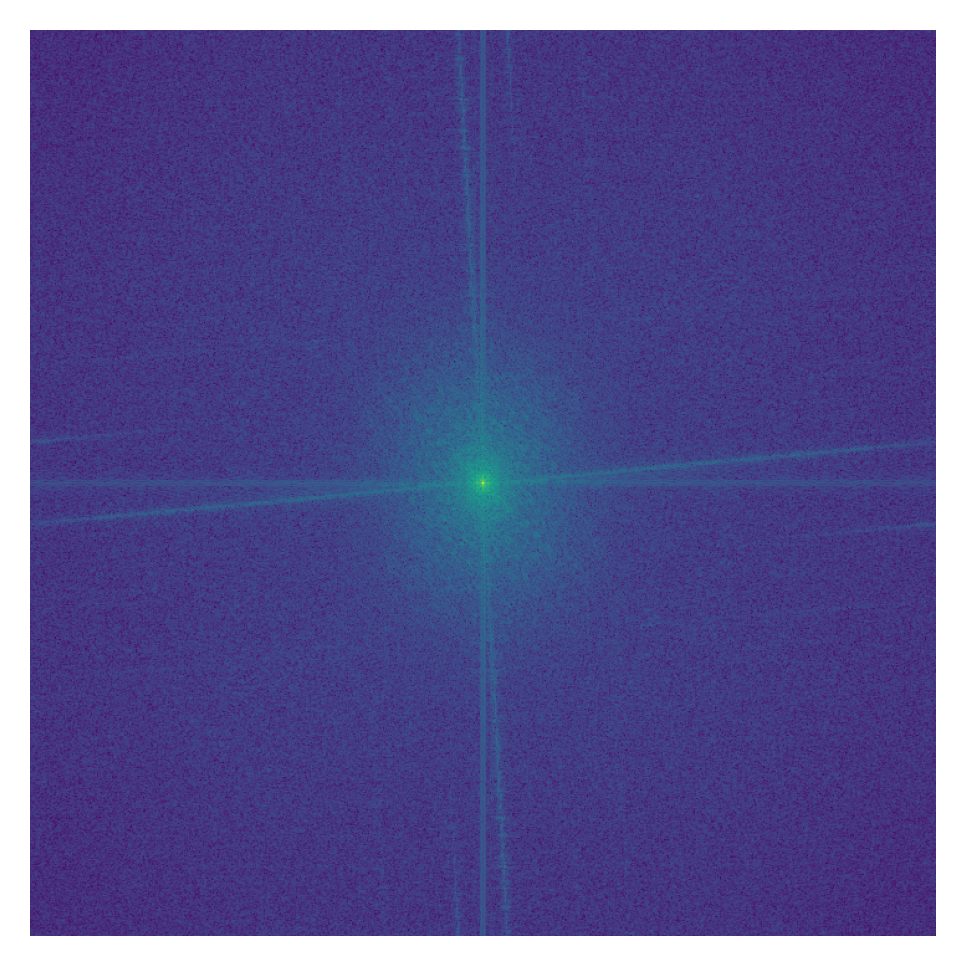

In [192]:
_data = data.x_data.squeeze().cuda()

model = MGNNds(xc = _data[0, :, :], 
               weight_matrix = _data[2, :, :],
               outlier_mask = _data[1, :, :]).cuda()    
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
loss = Loss().cuda()
for epoch in range(500):
    model, _, recon, stripe = train(model, train_loader, optimizer, loss, epoch)

aux_path = path = os.path.join(PARENT_PATH, 'destripe/Data/original.mat')
original = h5py.File(aux_path, 'r')['datas'][:].transpose(0, 2, 1)[0, :, :]
original = torch.log10(torch.from_numpy(original.astype('float32')).cuda())

plt.figure(dpi = 300)
plt.imshow(recon.cpu().data.numpy())
plt.axis('off')

plt.figure(dpi = 300)
plt.imshow(torch.log10(original.squeeze()).cpu().data.numpy())
plt.axis('off')

plt.figure(dpi = 300)
plt.imshow(torch.log10(torch.abs(fft.fftshift(fft.fft2(recon)))+1).cpu().data.numpy())
plt.axis('off')

plt.figure(dpi = 300)
plt.imshow(torch.log10(torch.abs(fft.fftshift(fft.fft2(original)))+1).cpu().data.numpy())
plt.axis('off')
#io.savemat('recon{}.mat'.format(epoch), {'recon': recon.cpu().data.numpy()})
#io.savemat('stripe{}.mat'.format(epoch), {'stripe': stripe.cpu().data.numpy()})
# data = io.loadmat('Data/oneround.mat')['data']
# plt.figure(dpi = 300)
# plt.imshow(data-recon.cpu().data.numpy())
# plt.axis('off')

In [71]:
# data[0]